In [1]:
import yaml
import sys
import os
from Model.CacheModel_v2 import CacheModel
from datasets import build_dataset
from datasets.utils import build_data_loader
from Model.model import Mask_SAM
data_config_p= 'Configs/Synapse_config.yml' 
model_config_p= 'Configs/model_config.yml' 
with open(data_config_p, 'r') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)
with open(model_config_p, 'r') as f:
    model_config = yaml.load(f, Loader=yaml.FullLoader)
model_config['img_size'] = 512
pretrained_path = '/home/chen0063/SINICA/MaskSAM/checkpoints/03-07_18:54'
data_config = data_config['data']
device = 'cuda:0'

In [42]:
import torch
with torch.no_grad():
    # model settings
    model_config['img_size'] = data_config['img_size']
    USE_LORA = model_config['settings']['USE_LORA']
    USE_TEXT_PROMPT = model_config['settings']['USE_TEXT_PROMPT']
    USE_MASK_PROMPT = model_config['settings']['USE_MASK_PROMPT']
    train_cache = model_config['training']['train_cache']

    model = Mask_SAM(model_config, device)
    if USE_LORA:
        model.add_lora()

    CM = None
    if USE_MASK_PROMPT:
        CM = CacheModel(model=model,train_loader_cache=None, image_path=data_config['image_path'],train_cache=train_cache, save_or_load_path=pretrained_path, device=device,tp_path=model_config['tp_ckpt_path'])      
        if train_cache:
                model.CM = CM
    if pretrained_path is not None:
        state_dict = torch.load(os.path.join(pretrained_path, 'model_ckpt.pth'),map_location='cpu')
        model.load_state_dict(state_dict, strict=True)
        if USE_LORA:
            model.load_lora_parameters(os.path.join(pretrained_path, 'lora_p.pth'))

    model = model.to(device)
    model.eval()
    # prepare data
    dataset = build_dataset(data_config, image_in_cache=None,is_cache=False, model=None)
    test_dataloader = build_data_loader(data_source=dataset.test, batch_size=1, shuffle=False, desired_size=data_config['img_size'])

{'USE_TEXT_PROMPT': True, 'USE_MASK_PROMPT': True, 'USE_LORA': True}
ptype masks loaded
cache keys loaded
Reading split from /work/chen0063/Synapse/data_notall_shuffle.json


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional
from torchvision import transforms
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=2, gamma=3, ignore_index=None, reduction='none', **kwargs):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = 1e-6  # set '1e-4' when train with FP16
        self.ignore_index = ignore_index
        self.reduction = reduction

        assert self.reduction in ['none', 'mean', 'sum']

    def forward(self, output, target, labels=None, label_weight=None):
        prob = torch.sigmoid(output)
        prob = torch.clamp(prob, self.smooth, 1.0 - self.smooth)

        pos_mask = (target == 1).float()
        neg_mask = (target == 0).float()

        pos_weight = (pos_mask * torch.pow(1 - prob, self.gamma)).detach()
        pos_loss = -pos_weight * torch.log(prob)  # / (torch.sum(pos_weight) + 1e-4)

        neg_weight = (neg_mask * torch.pow(prob, self.gamma)).detach()
        neg_loss = -self.alpha * neg_weight * F.logsigmoid(-output)  # / (torch.sum(neg_weight) + 1e-4)
        loss = pos_loss + neg_loss
        return loss

class BinaryAdjustDiceLoss(nn.Module):
    """
    Dice coefficient for short, is an F1-oriented statistic used to gauge the similarity of two sets.
    Given two sets A and B, the vanilla dice coefficient between them is given as follows:
        Dice(A, B)  = 2 * True_Positive / (2 * True_Positive + False_Positive + False_Negative)
                    = 2 * |A and B| / (|A| + |B|)

    Math Function:
        U-NET: https://arxiv.org/abs/1505.04597.pdf
        dice_loss(p, y) = 1 - numerator / denominator
            numerator = 2 * \sum_{1}^{t} p_i * y_i + smooth
            denominator = \sum_{1}^{t} p_i + \sum_{1} ^{t} y_i + smooth
        if square_denominator is True, the denominator is \sum_{1}^{t} (p_i ** 2) + \sum_{1} ^{t} (y_i ** 2) + smooth
        V-NET: https://arxiv.org/abs/1606.04797.pdf
    Args:
        smooth (float, optional): a manual smooth value for numerator and denominator.
        square_denominator (bool, optional): [True, False], specifies whether to square the denominator in the loss function.
        with_logits (bool, optional): [True, False], specifies whether the input tensor is normalized by Sigmoid/Softmax funcs.
        ohem_ratio: max ratio of positive/negative, defautls to 0.0, which means no ohem.
        alpha: dsc alpha
    """
    def __init__(self,
                 smooth: Optional[float] = 1e-4,
                 square_denominator: Optional[bool] = False,
                 with_logits: Optional[bool] = True,
                 ohem_ratios = [0.0],
                 alpha: float = 3,
                 reduction: Optional[str] = "mean",
                 index_label_position=True) -> None:
        super(BinaryAdjustDiceLoss, self).__init__()

        self.reduction = reduction
        self.with_logits = with_logits
        self.smooth = smooth
        self.square_denominator = square_denominator
        self.ohem_ratios = ohem_ratios
        self.alpha = alpha
        self.index_label_position = index_label_position

    def forward(self, input: Tensor, target: Tensor,label: Tensor , mask: Optional[Tensor] = None) -> Tensor:
        loss = self._binary_class(input, target,label, mask=mask)

        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss

    def _compute_dice_loss(self, flat_input, flat_target):
        flat_input = ((1 - flat_input) ** self.alpha) * flat_input
        interection = torch.sum(flat_input * flat_target, -1)
        if not self.square_denominator:
            loss = 1 - ((2 * interection + self.smooth) /
                        (flat_input.sum() + flat_target.sum() + self.smooth))
        else:
            loss = 1 - ((2 * interection + self.smooth) /
                        (torch.sum(torch.square(flat_input, ), -1) + torch.sum(torch.square(flat_target), -1) + self.smooth))

        return loss

    def _binary_class(self, input, target, label, mask=None):
        batchsize = input.size(0)
        flat_input = input.view(batchsize, -1)
        flat_target = target.view(batchsize, -1).float()

        flat_input = torch.sigmoid(flat_input) 
        if mask is not None:
            mask = mask.float()
            flat_input = flat_input * mask
            flat_target = flat_target * mask
        else:
            mask = torch.ones_like(flat_target)

        for i in range(batchsize):
            if self.ohem_ratios[label[i]] > 0:
                pos_example = flat_target[i] > 0.5
                neg_example = flat_target[i] <= 0.5
                mask_neg_num = mask[i] <= 0.5

                pos_num = pos_example.sum() - (pos_example & mask_neg_num).sum()
                neg_num = neg_example.sum()
                print(pos_example.sum(),pos_num,neg_num)
                keep_num = min(int(pos_num * self.ohem_ratios[label[i]]), neg_num)
                print(keep_num)
                neg_scores = torch.masked_select(flat_input[i], neg_example.bool())
                neg_scores_sort, _ = torch.sort(neg_scores, )
                threshold = neg_scores_sort[-keep_num+1]
                print(threshold,flat_input[i].min(),flat_input[i].max())
                cond = (flat_input[i] > threshold) | pos_example.view(-1)
                ohem_mask = torch.where(cond, 1, 0)
                
                
                fig = plt.figure(figsize=(10, 12))
                plt.subplot(1, 4, 1)
                plt.imshow(flat_input[i].view((512,512)).cpu().detach().numpy())
                plt.title(f'pred')

                plt.subplot(1, 4, 2)
                plt.imshow(flat_target[i].view((512,512)).cpu().detach().numpy())
                plt.title(f'target')

                plt.subplot(1, 4, 3)
                plt.imshow((flat_input[i]* ohem_mask).view((512,512)).cpu().detach().numpy())
                plt.title(f'threshold pred')

                plt.subplot(1, 4, 4)
                plt.imshow((flat_target[i]* ohem_mask).view((512,512)).cpu().detach().numpy())
                plt.title(f'threshold target')
                
                flat_input[i] = flat_input[i] * ohem_mask
                flat_target[i] = flat_target[i] * ohem_mask

        return self._compute_dice_loss(flat_input, flat_target)
    
def dice_loss(predict, target, labels=None, label_weight=None):
    assert predict.size() == target.size(), "the size of predict and target must be equal."
    epsilon = 1e-5
    num = predict.size(0)
    
    pre = torch.sigmoid(predict).view(num, -1)
    tar = target.view(num, -1)
    
    intersection = (pre * tar).sum(-1).sum()
    union = (pre + tar).sum(-1).sum()
#     print(intersection,union)
    
    score = 1 -  (2.0 * intersection + epsilon) / (union + epsilon)
    
    return 'Dice loss', score

  0%|          | 1/12544 [00:00<44:06,  4.74it/s]

tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(262144, device='cuda:0')
0
tensor(2.1974e-08, device='cuda:0') tensor(2.0054e-08, device='cuda:0') tensor(0.0490, device='cuda:0')


  0%|          | 2/12544 [00:00<44:50,  4.66it/s]

tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(262144, device='cuda:0')
0
tensor(4.6749e-09, device='cuda:0') tensor(4.5335e-09, device='cuda:0') tensor(0.0354, device='cuda:0')
2


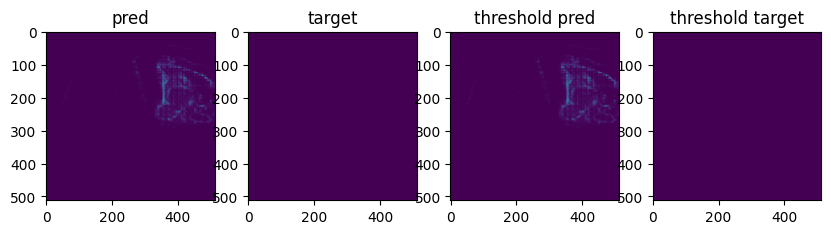

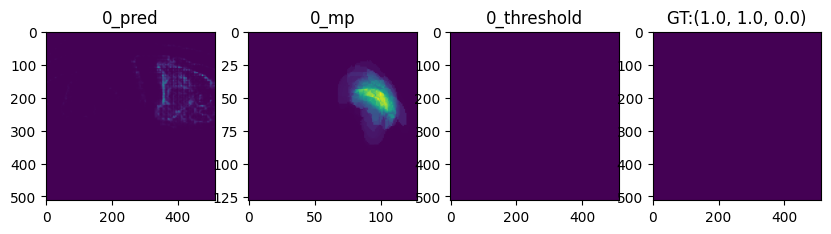

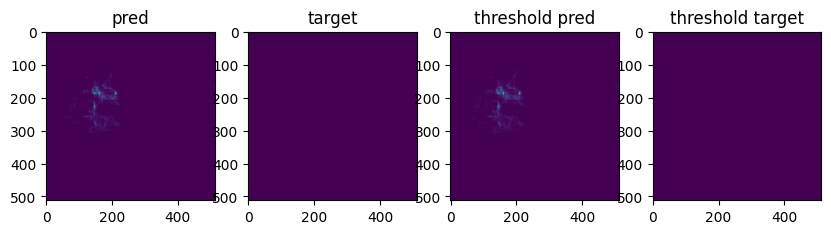

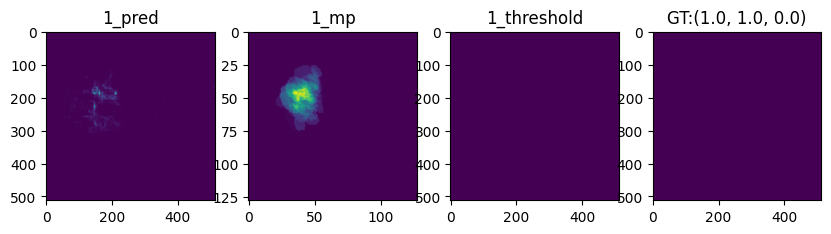

In [60]:
from tqdm import tqdm
import matplotlib.pyplot as plt   
import numpy as np
ratios=np.round(np.array([0.31685527, 0.32872596, 0.32553957, 0.11497731, 0.70076923,
       0.36734694, 1.21987952, 0.24143739]),3)
bar = tqdm(enumerate(test_dataloader), total = len(test_dataloader))
i2l =  ['spleen','right kidney','left kidney','gallbladder','liver','stomach','aorta','pancreas']
count=0
with torch.no_grad():
    loss_func = BinaryAdjustDiceLoss(alpha=0,ohem_ratios=ratios)
    focal_loss =BinaryFocalLoss()
    for step, batch in bar:
        if count > 1:
            print(step)
            break
        image, label, GT, case,SN = batch
#         if (GT.sum()==0):
#             continue
        img_embeds = model.sam.image_encoder(image.to(device))
        if CM is not None:
            if train_cache:
                model.CM.eval()
                mask_prompts =  model.CM(img_embeds=img_embeds,case=case, label=label, beta=10)
            else:   
                mask_prompts =  CM(img_embeds=img_embeds,case=case, label=label, beta=10)

        text  = [i2l[i] for i in label.numpy()]
        if (CM is not None) and USE_TEXT_PROMPT: # using both text and mask
            predict_mask = model(image_embeddings=img_embeds, mask_prompts=mask_prompts.unsqueeze(1), alpha=0.5, x_text=text).squeeze(1)
        elif USE_TEXT: # using only text
            predict_mask = model(image_embeddings=img_embeds, mask_prompts=None, alpha=alpha, x_text=text).squeeze(1)
        else: # using only mask
            predict_mask = model(image_embeddings=img_embeds, mask_prompts=mask_prompts.unsqueeze(1), alpha=alpha).squeeze(1)
        
        # predict_mask = F.interpolate(predict_mask, (512, 512) , mode="bilinear", align_corners=False).squeeze(1)
        if GT.shape[-2:] != predict_mask.shape[-2:]:
            GT = F.interpolate(GT.float().unsqueeze(1), size=predict_mask.shape[-2:], mode='bicubic').squeeze(1) > 0
        dloss = loss_func(predict_mask, GT.to(device), label)
        diceloss = dice_loss(predict_mask, GT.to(device))
        f = focal_loss(predict_mask, GT.to(device))
        
        sigmoid_predict_mask = torch.sigmoid(predict_mask).detach().cpu().numpy()
        
        threshold_mask = (sigmoid_predict_mask)>0.5
        
        fig = plt.figure(figsize=(10, 12))
        plt.subplot(1, 4, 1)
        plt.imshow(sigmoid_predict_mask[0])
        plt.title(f'{label[0]}_pred')
        
        plt.subplot(1, 4, 2)
        plt.imshow(mask_prompts.cpu().detach().numpy()[0])
        plt.title(f'{label[0]}_mp')
        
        plt.subplot(1, 4, 3)
        plt.imshow(threshold_mask[0])
        plt.title(f'{label[0]}_threshold')

        plt.subplot(1, 4, 4)
        plt.imshow(GT.cpu().detach().numpy()[0])
        plt.title(f'GT:{round(dloss.item(),4),round(diceloss[1].item(),4),round(f.mean().item(),5)}')
        count +=1

In [64]:
inputs = torch.rand(1,3,2,2)
inputs

tensor([[[[0.3022, 0.1125],
          [0.5528, 0.2149]],

         [[0.0275, 0.6958],
          [0.6188, 0.8072]],

         [[0.6863, 0.1500],
          [0.2688, 0.7049]]]])

In [65]:
inputs = torch.softmax(inputs,dim=1)
inputs

tensor([[[[0.3098, 0.2611],
          [0.3545, 0.2252]],

         [[0.2354, 0.4679],
          [0.3787, 0.4072]],

         [[0.4548, 0.2711],
          [0.2668, 0.3676]]]])

In [66]:
inputs[:,0]

tensor([[[0.3098, 0.2611],
         [0.3545, 0.2252]]])

In [9]:
import torch
def compute_mask(output, target, threshold):
    condition = ((output > threshold).sum(dim=[1, 2]) == 0) & (target.sum(dim=[1, 2]) == 0)
    mask = condition.view(-1, 1, 1).float()
    return mask


output =  torch.randint(0,10,(2,2,2))
GT =  torch.randint(0,1,(2,2,2))
mask=compute_mask(output,GT,5)
print(output*(1-mask))

tensor([[[4, 3],
         [1, 5]],

        [[7, 6],
         [2, 5]]])
tensor([[[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]]])
tensor([[[1.]],

        [[0.]]])
tensor([[[0., 0.],
         [0., 0.]],

        [[7., 6.],
         [2., 5.]]])
